# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration, Cleaning, Preparing, and Transforming ###
In this section we will explore the data available (luckily already retrieved) and clean it up a bit. Lets begin with looking at each pandas object (dataframe) created by reading in the JSON files.

In [2]:
print(portfolio)

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  229

There appears to be 9 types of offers to analyse to customer demographics. Remember that "difficulty" is the minimum requried to spend and the "reward" is the discount on price. Duration is measured in days. "Channels" are the ways in which customers are reached. 

Let's start by relabeling the columns for easier reading and expanding "channels" to individual categories with binary values of with 1 indicating a channel used and 0 meaning it wasn't used for the offer.

Also, the 'offer_type' column is probably significant, but strings won't hold a mathematical value in the algorithms, so change them to numerical representations. (1-bogo, 2-informational, 3-discount)

In [3]:
# rename 'reward' and 'difficulty' columns
portfolio.rename(columns = {'reward':'discount'}, inplace = True)
portfolio.rename(columns = {'difficulty':'min_spend_req'}, inplace = True)

# change 'channels' column  to 4 columns labeled as 'web', 'email', 'mobile', and 'social' with bianry values
try:
    portfolio.insert(2, "web", 0)
    portfolio.insert(2, "email", 0)
    portfolio.insert(2, "mobile", 0)
    portfolio.insert(2, "social", 0)
except: # prevents add error if already ran cell once for trying to insert an existing column
    pass

# Have to iterate instead of one-hot encode becuase values are string array format
try:
    for index, row in portfolio.iterrows():
        string_array = portfolio.channels[index]
        for v in string_array:
            if v == 'web':
                portfolio.loc[index, 'web'] = 1
            elif v == 'email':
                portfolio.loc[index, 'email'] = 1
            elif v =='mobile':
                portfolio.loc[index, 'mobile'] = 1
            elif v == 'social':
                portfolio.loc[index, 'social'] = 1
except: # prevents add error if already ran cell once for trying to insert an existing column
    pass

# one-hot encode 'offer_type' to express numerical values
# Make dummy variables for 'offer_type'
one_hot_data = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'], prefix="type")], axis=1)

# Drop the previous 'rank' column
one_hot_data = one_hot_data.drop('offer_type', axis=1)

# delete old channels column
try:
    portfolio = one_hot_data.drop('channels', 1)
except: # prevents add error if already ran cell once for trying to insert an existing column
    pass

# As seen above, all the offers were sent via email. This will make that feature meaningless for our purposes here. 
# In other cases it might be important, but to avoid over bias or unnecessary calculations we will remove it.
try:
    portfolio_clean = portfolio.drop('email', 1)
except: # prevents add error if already ran cell once for trying to insert an existing column
    pass

In [4]:
# print out the dataframe to ensure all changes are correct
print(portfolio_clean)

   min_spend_req  social  mobile  web  duration  \
0             10       1       1    0         7   
1             10       1       1    1         5   
2              0       0       1    1         4   
3              5       0       1    1         7   
4             20       0       0    1        10   
5              7       1       1    1         7   
6             10       1       1    1        10   
7              0       1       1    0         3   
8              5       1       1    1         5   
9             10       0       1    1         7   

                                 id  discount  type_bogo  type_discount  \
0  ae264e3637204a6fb9bb56bc8210ddfd        10          1              0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0        10          1              0   
2  3f207df678b143eea3cee63160fa8bed         0          0              0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9         5          1              0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7         5          0       

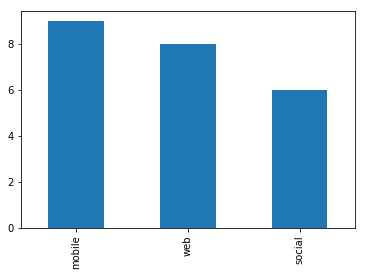

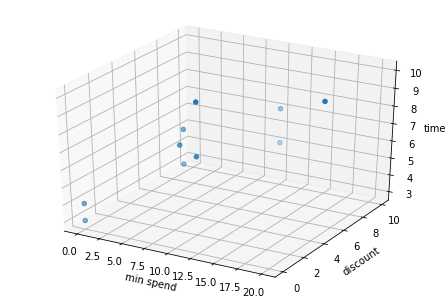

In [19]:
df = portfolio_clean.filter(['mobile','web', 'social'], axis=1)

df.sum(axis=0).plot.bar()

# portfolio_clean.plot(x='min_spend_req', y='discount', z='duration', style='o')

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

ax.set_xlabel('min spend')
ax.set_ylabel('discount')
ax.set_zlabel('time')

ax.scatter(portfolio_clean.min_spend_req, portfolio_clean.discount, portfolio_clean.duration)
pyplot.show()

In [20]:
# Inspect Profile dataframe
print(profile)

       age  became_member_on gender                                id  \
0      118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783   
1       55          20170715      F  0610b486422d4921ae7d2bf64640c50b   
2      118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5   
3       75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef   
4      118          20170804   None  a03223e636434f42ac4c3df47e8bac43   
5       68          20180426      M  e2127556f4f64592b11af22de27a7932   
6      118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586   
7      118          20171002   None  68617ca6246f4fbc85e91a2a49552598   
8       65          20180209      M  389bc3fa690240e798340f5a15918d5c   
9      118          20161122   None  8974fc5686fe429db53ddde067b88302   
10     118          20170824   None  c4863c7985cf408faee930f111475da3   
11     118          20150919   None  148adfcaa27d485b82f323aaaad036bd   
12      58          20171111      M  2eeac8d8feae4a

This looks like it should be combined into the same object, as income is a trait and there is no need to duplicate the ids. We should also change the gender to numerical values. (Arbitrarily picked, let's say 1 = 'M', 2 = 'F', and 3 = 'None'.) 

We should also change incomes of 'NaN' to -1. This will keep a numerical constanst for that value for correlational purposes, while also not conflicting with any possible values of '0' for people reporting no income which is vastly different than just not wanting to say.

##### NOTE: MAY NEED TO CHANGE INCOME TO RANGES WITH SET VALUES AS 'NaN' BEING -1 COULD CAUSE A CONTINUOUS CALCULATION ERROR IF THEIR IS SIGNIFICANT DIFFERENCE BETWEEN 'NaN' GROUPS AND '0' INCOME GROUPS. ####

##### NOTE: There are no initial incomes listed as being 0, so we can try changing all 'NaN's to 0 and test later with and without this data point to see if the correlation matters significantly or not. #####

The 'became_member_on' column can also be conveted to Unix Time Stamps for more uniform calculations as YYYYMMDD wouldn't translate to a base 10 and thus could potentially throw off our algorithms. (Although, it would be interesting to see how an algorithm performs without this change and compare the two models if given enough time and resources.)

In [21]:
# change 'gender' column to numerical values (1=male, 2=female, 3=other/none)
# one hot encode to help train models
# see: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f for more information
# profile.gender.fillna(value='None', inplace=True)

try:
    # to treat no answers as a separate feature as it might be significant
    profile.gender.fillna('none', inplace=True)
    
    # Make dummy variables for 'gender'
    profile_hot = pd.concat([profile, pd.get_dummies(profile['gender'], prefix='gender')], axis=1)
    
#     pd.get_dummies(test).reindex(columns=train_encoded.columns)

    # Drop the previous 'gender' column
    profile = profile_hot.drop('gender', axis=1)
except:
    pass

# ############################################################################################################
# # change 'NaN' values of income to 0
# # (RETODO LATER???: Change income values to labeled range columns? This might help when determinining if data for income
# # is best calculated in descrete tests )
# print(profile.isnull().sum().sum())
# # create alternative dataframes to train depending on income
# profile_nonulls = profile.copy()
# profile_nonulls = profile_nonulls[np.isfinite(profile['income'])]
# print(profile_nonulls.head())

# profile_zeroed_income = profile.copy()
# profile_zeroed_income.income.fillna(value=0, inplace=True)
# print(profile_zeroed_income.head())   
# #############################################################################################################

# converting to days since joining later...
# change date formats to Unix timestamps instead of YYYYMMDD
# import time
# import datetime
# from IPython.display import clear_output
# try:
#     for index, row in profile.iterrows():
        
# #         clear_output(wait=True)
        
#         date = str(profile.loc[index, 'became_member_on'])
#         unix_time = time.mktime(datetime.datetime.strptime(date, "%Y%m%d").timetuple())
#         profile.loc[index, 'became_member_on'] = unix_time
        
# #         print("Current progress:", np.round(index/len(profile) * 100, 2), "%")
        
# except:
#     pass

profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [22]:
# Verify if profile formatted correctly
print(profile)

       age  became_member_on                       customer_id    income  \
0      118          20170212  68be06ca386d4c31939f3a4f0e3dd783       NaN   
1       55          20170715  0610b486422d4921ae7d2bf64640c50b  112000.0   
2      118          20180712  38fe809add3b4fcf9315a9694bb96ff5       NaN   
3       75          20170509  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
4      118          20170804  a03223e636434f42ac4c3df47e8bac43       NaN   
5       68          20180426  e2127556f4f64592b11af22de27a7932   70000.0   
6      118          20170925  8ec6ce2a7e7949b1bf142def7d0e0586       NaN   
7      118          20171002  68617ca6246f4fbc85e91a2a49552598       NaN   
8       65          20180209  389bc3fa690240e798340f5a15918d5c   53000.0   
9      118          20161122  8974fc5686fe429db53ddde067b88302       NaN   
10     118          20170824  c4863c7985cf408faee930f111475da3       NaN   
11     118          20150919  148adfcaa27d485b82f323aaaad036bd       NaN   
12      58  

In [23]:
print(profile.loc[profile['age'] > 100])

print(profile.loc[profile['gender_none'] == 1])

print(profile.loc[profile['income'].isnull()])

       age  became_member_on                       customer_id   income  \
0      118          20170212  68be06ca386d4c31939f3a4f0e3dd783      NaN   
2      118          20180712  38fe809add3b4fcf9315a9694bb96ff5      NaN   
4      118          20170804  a03223e636434f42ac4c3df47e8bac43      NaN   
6      118          20170925  8ec6ce2a7e7949b1bf142def7d0e0586      NaN   
7      118          20171002  68617ca6246f4fbc85e91a2a49552598      NaN   
9      118          20161122  8974fc5686fe429db53ddde067b88302      NaN   
10     118          20170824  c4863c7985cf408faee930f111475da3      NaN   
11     118          20150919  148adfcaa27d485b82f323aaaad036bd      NaN   
17     118          20170801  744d603ef08c4f33af5a61c8c7628d1c      NaN   
23     118          20170907  2b826eba31074a059d63b0ae8f50b7d5      NaN   
26     118          20170330  65aba5c617294649aeb624da249e1ee5      NaN   
36     118          20160707  4beeb3ed64dd4898b0edf2f6b67426d3      NaN   
39     118          20180

It appears that anyone who didn't enter or wish to share their demographics have null income values, default set age of 118, and their gender is none (added column to accept "no gender preference" responses, but looks like its part of just no demographics portion of data), so we should save two different datasets to train to avoid possible skewed results due to unbalanced age and income. (If we set null incomes to zero, it might disproportionally affect training.)

In [24]:
import numpy as np

profile_clean = profile[np.isfinite(profile['income'])] #only include customers who entered income values

# We see no more age of 118, meaning it must default to that maximum value if customer decided not to include demographic information
print(profile_clean.loc[profile_clean['age'] > 100]) 

# We see that no more records of no gender when we dropped null income probably because customers opted out of all information
print(profile_clean.loc[profile_clean['gender_none'] == 1])

# No customers entered 0 as income
print(profile_clean.loc[profile_clean['income'] == 0])

       age  became_member_on                       customer_id   income  \
1556   101          20171004  4d2ccfcbbebf4bd9baf4b7e433d0e288  43000.0   
4100   101          20150526  d2fdc2be8ab64e4ba04830d441e53fd5  99000.0   
14846  101          20171109  e0ea90ddd2f147e082d21e97f51ec1b1  56000.0   
15800  101          20170309  047ad0135cfe4c0ea5ba019da4de9c52  59000.0   
16864  101          20171127  1593d617fac246ef8e50dbb0ffd77f5f  82000.0   

       gender_F  gender_M  gender_O  gender_none  
1556          1         0         0            0  
4100          1         0         0            0  
14846         1         0         0            0  
15800         1         0         0            0  
16864         1         0         0            0  
Empty DataFrame
Columns: [age, became_member_on, customer_id, income, gender_F, gender_M, gender_O, gender_none]
Index: []
Empty DataFrame
Columns: [age, became_member_on, customer_id, income, gender_F, gender_M, gender_O, gender_none]
Index: 

The initial suspicion seems to be confimed here, as there are no more rows with 118 age or none as gender after dropping all rows where income doesn't have a value. This makes the 'none' gender column obsolete and thus we can drop it.

In [25]:
profile_clean = profile_clean.drop('gender_none', 1)
print(profile_clean) #verify profile data is cleaned up

       age  became_member_on                       customer_id    income  \
1       55          20170715  0610b486422d4921ae7d2bf64640c50b  112000.0   
3       75          20170509  78afa995795e4d85b5d9ceeca43f5fef  100000.0   
5       68          20180426  e2127556f4f64592b11af22de27a7932   70000.0   
8       65          20180209  389bc3fa690240e798340f5a15918d5c   53000.0   
12      58          20171111  2eeac8d8feae4a8cad5a6af0499a211d   51000.0   
13      61          20170911  aa4862eba776480b8bb9c68455b8c2e1   57000.0   
14      26          20140213  e12aeaf2d47d42479ea1c4ac3d8286c6   46000.0   
15      62          20160211  31dda685af34476cad5bc968bdb01c53   71000.0   
16      49          20141113  62cf5e10845442329191fc246e7bcea3   52000.0   
18      57          20171231  6445de3b47274c759400cd68131d91b4   42000.0   
19      61          20180501  a448667f336b42c9a66fc5ffd5d73772   40000.0   
20      40          20160504  440cf1fd7580490c971d8c651ed962af   71000.0   
21      64  

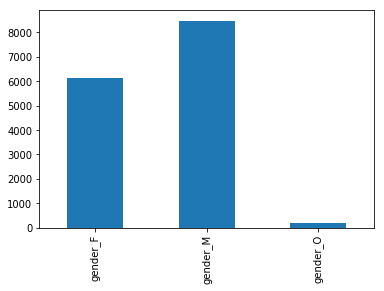

In [26]:
df = profile_clean.filter(['gender_F','gender_M', 'gender_O'], axis=1)

df.sum(axis=0).plot.bar()

In [27]:
# Inspect transcript data
print(transcript)

                  event                            person  time  \
0        offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1        offer received  a03223e636434f42ac4c3df47e8bac43     0   
2        offer received  e2127556f4f64592b11af22de27a7932     0   
3        offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4        offer received  68617ca6246f4fbc85e91a2a49552598     0   
5        offer received  389bc3fa690240e798340f5a15918d5c     0   
6        offer received  c4863c7985cf408faee930f111475da3     0   
7        offer received  2eeac8d8feae4a8cad5a6af0499a211d     0   
8        offer received  aa4862eba776480b8bb9c68455b8c2e1     0   
9        offer received  31dda685af34476cad5bc968bdb01c53     0   
10       offer received  744d603ef08c4f33af5a61c8c7628d1c     0   
11       offer received  3d02345581554e81b7b289ab5e288078     0   
12       offer received  4b0da7e80e5945209a1fdddfe813dbe0     0   
13       offer received  c27e0d6ab72c455a8bb66d980963de60     

In [28]:
# one-hot encode data for events to be binary values
# Make dummy variables for 'event'
transcript_one_hot = pd.concat([transcript, pd.get_dummies(transcript['event'], prefix='event')], axis=1)

# Drop the previous 'rank' column
transcript_one_hot = transcript_one_hot.drop('event', axis=1)

print(transcript_one_hot)

                                  person  time  \
0       78afa995795e4d85b5d9ceeca43f5fef     0   
1       a03223e636434f42ac4c3df47e8bac43     0   
2       e2127556f4f64592b11af22de27a7932     0   
3       8ec6ce2a7e7949b1bf142def7d0e0586     0   
4       68617ca6246f4fbc85e91a2a49552598     0   
5       389bc3fa690240e798340f5a15918d5c     0   
6       c4863c7985cf408faee930f111475da3     0   
7       2eeac8d8feae4a8cad5a6af0499a211d     0   
8       aa4862eba776480b8bb9c68455b8c2e1     0   
9       31dda685af34476cad5bc968bdb01c53     0   
10      744d603ef08c4f33af5a61c8c7628d1c     0   
11      3d02345581554e81b7b289ab5e288078     0   
12      4b0da7e80e5945209a1fdddfe813dbe0     0   
13      c27e0d6ab72c455a8bb66d980963de60     0   
14      d53717f5400c4e84affdaeda9dd926b3     0   
15      f806632c011441378d4646567f357a21     0   
16      d058f73bf8674a26a95227db098147b1     0   
17      65aba5c617294649aeb624da249e1ee5     0   
18      ebe7ef46ea6f4963a7dd49f501b26779     0   


In [29]:
# Rename columns with underscore for consistency
transcript_one_hot.rename(columns = {'event_offer completed':'event_offer_completed'}, inplace = True)
transcript_one_hot.rename(columns = {'event_offer received':'event_offer_received'}, inplace = True)
transcript_one_hot.rename(columns = {'event_offer viewed':'event_offer_viewed'}, inplace = True)

print(transcript_one_hot)

                                  person  time  \
0       78afa995795e4d85b5d9ceeca43f5fef     0   
1       a03223e636434f42ac4c3df47e8bac43     0   
2       e2127556f4f64592b11af22de27a7932     0   
3       8ec6ce2a7e7949b1bf142def7d0e0586     0   
4       68617ca6246f4fbc85e91a2a49552598     0   
5       389bc3fa690240e798340f5a15918d5c     0   
6       c4863c7985cf408faee930f111475da3     0   
7       2eeac8d8feae4a8cad5a6af0499a211d     0   
8       aa4862eba776480b8bb9c68455b8c2e1     0   
9       31dda685af34476cad5bc968bdb01c53     0   
10      744d603ef08c4f33af5a61c8c7628d1c     0   
11      3d02345581554e81b7b289ab5e288078     0   
12      4b0da7e80e5945209a1fdddfe813dbe0     0   
13      c27e0d6ab72c455a8bb66d980963de60     0   
14      d53717f5400c4e84affdaeda9dd926b3     0   
15      f806632c011441378d4646567f357a21     0   
16      d058f73bf8674a26a95227db098147b1     0   
17      65aba5c617294649aeb624da249e1ee5     0   
18      ebe7ef46ea6f4963a7dd49f501b26779     0   


In [30]:
import pandas as pd
from pandas.io.json import json_normalize

transcript_hot_copy = transcript_one_hot.copy()

# extract values into separate columns 
# (WHAT A FREAKING TIME SAVING FUNCTION!!! Thank you to whoever wrote this pandas function!!!!)
transcript_hot_copy = json_normalize(transcript_hot_copy['value'])

In [31]:
result = pd.concat([transcript_one_hot, transcript_hot_copy], axis=1)

df = result['offer id'].fillna(result['offer_id'])

transcript_clean = pd.concat([result, df.rename('ID')], axis=1)
transcript_clean = transcript_clean.drop('offer id', axis=1)
transcript_clean = transcript_clean.drop('offer_id', axis=1)
transcript_clean = transcript_clean.drop('value', axis=1)
transcript_clean.rename(columns = {'ID':'offer_id'}, inplace = True)
transcript_clean.rename(columns = {'person':'customer_id'}, inplace = True)

print(transcript_clean)

                             customer_id  time  event_offer_completed  \
0       78afa995795e4d85b5d9ceeca43f5fef     0                      0   
1       a03223e636434f42ac4c3df47e8bac43     0                      0   
2       e2127556f4f64592b11af22de27a7932     0                      0   
3       8ec6ce2a7e7949b1bf142def7d0e0586     0                      0   
4       68617ca6246f4fbc85e91a2a49552598     0                      0   
5       389bc3fa690240e798340f5a15918d5c     0                      0   
6       c4863c7985cf408faee930f111475da3     0                      0   
7       2eeac8d8feae4a8cad5a6af0499a211d     0                      0   
8       aa4862eba776480b8bb9c68455b8c2e1     0                      0   
9       31dda685af34476cad5bc968bdb01c53     0                      0   
10      744d603ef08c4f33af5a61c8c7628d1c     0                      0   
11      3d02345581554e81b7b289ab5e288078     0                      0   
12      4b0da7e80e5945209a1fdddfe813dbe0     0     

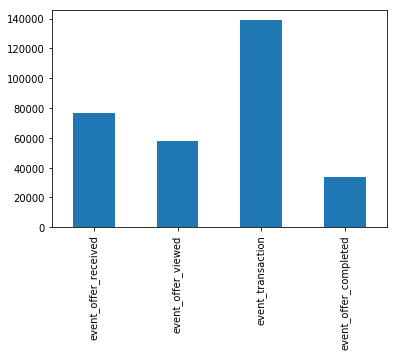

In [32]:
df = transcript_clean.filter(['event_offer_received','event_offer_viewed', 'event_transaction', 'event_offer_completed'], axis=1)

df.sum(axis=0).plot.bar()

### SAVE CLEANED UP DATAFRAMES AND COMBINED DATAFRAMES ##

In [ ]:
# Save dataframes to new CSV files to avoid lengthly data preprocessing steps if leave and come back to project
# IF RUNNING LOCALLY!
# portfolio_clean.to_csv('./clean_data/portfolio.csv')

# profile_clean.to_csv('./clean_data/profile_clean.csv')

# transcript_clean.to_csv('./clean_data/transcript.csv')

In [33]:
# Save dataframes to new CSV files to avoid lengthly data preprocessing steps if leave and come back to project
# IF RUNNING ON AWS!

import os

data_dir = 'clean_data'
filename1 = 'portfolio_clean.csv'
filename2 = 'profile_clean.csv'
filename3 = 'transcript_clean.csv'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# first column is the labels and rest is features 
portfolio_clean.to_csv(os.path.join(data_dir, filename1))
profile_clean.to_csv(os.path.join(data_dir, filename2))
transcript_clean.to_csv(os.path.join(data_dir, filename3))


In [34]:
# NOTE: ONLY RUN THIS CELL IF COMING BACK AFTER DATA PREPROCESSING!!!!!!!!!!!!!!! 
# THIS WILL RELOAD SAVED CSV FILES BACK INTO MEMORY 
################################################
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the csv files
portfolio_clean = pd.read_csv('clean_data/portfolio_clean.csv', index_col=[0])
profile_clean = pd.read_csv('clean_data/profile_clean.csv', index_col=[0]) 
transcript_clean = pd.read_csv('clean_data/transcript_clean.csv', index_col=[0])
#################################################################


In [35]:
print(portfolio_clean)

print(profile_clean)

print(transcript_clean)

   min_spend_req  social  mobile  web  duration  \
0             10       1       1    0         7   
1             10       1       1    1         5   
2              0       0       1    1         4   
3              5       0       1    1         7   
4             20       0       0    1        10   
5              7       1       1    1         7   
6             10       1       1    1        10   
7              0       1       1    0         3   
8              5       1       1    1         5   
9             10       0       1    1         7   

                                 id  discount  type_bogo  type_discount  \
0  ae264e3637204a6fb9bb56bc8210ddfd        10          1              0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0        10          1              0   
2  3f207df678b143eea3cee63160fa8bed         0          0              0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9         5          1              0   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7         5          0       

Now, for some unsupervised algorithms to visualize some potential groupings and correlations amoung the data

##### Remember: 
We have 3 dataframes: 
* portfolio_clean - a list of promotions and associated data points
* profile_clean - a list of customer ids and some basic demographics minus all people who didn't enter demographics
* transcript_clean - a list of all types of deal interactions with customers

In [36]:
# TODO: Combine everything into one dataframe
transcript_clean.loc[transcript_clean['event_offer_completed'] == 1]

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,1,0,0,0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,1,0,0,0,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,1,0,0,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,1,0,0,0,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,1,0,0,0,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0
12717,227f2d69e46a4899b70d48182822cff6,0,1,0,0,0,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0
12721,bb0f25e23a4c4de6a645527c275cd594,0,1,0,0,0,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2
12744,d72d201be5794279aa716d8ad82b8d90,0,1,0,0,0,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
12764,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,1,0,0,0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
12767,3e621194f72e40d7a0b695ee9b7c38b7,0,1,0,0,0,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [37]:
# Merge all demographics into transactional dataframe
merged_df = transcript_clean.merge(profile_clean, how = 'inner', on = ['customer_id'])

In [38]:
# Remove 'customer_id' as it is no longer needed and cannot be used in our algorithms b/c it's not a number
merged_df = merged_df.drop('customer_id', 1)

In [39]:
# Remove transactions as our goal is to find coorelation of success, but extract it out for statisical analysis 
# of any possible correlation of amount spent and demographics. 
completed_offers = merged_df[merged_df.event_transaction != 1] 

In [40]:
# Clean up both new dataframes.
completed_offers = completed_offers.drop('event_transaction', 1)
completed_offers = completed_offers.drop('amount', 1)

In [41]:
# Combine offer columns into offers dataframe
portfolio_clean.rename(columns={'id': 'offer_id'}, inplace=True)
merged_df = completed_offers.merge(portfolio_clean, how = 'inner', on = ['offer_id'])

In [42]:
# Only extract completed offers for clustering and coorelational analysis
offers_completed_clean = merged_df.drop('offer_id', 1)
offers_completed_clean = offers_completed_clean[offers_completed_clean.event_offer_completed != 0] 
offers_completed_clean = offers_completed_clean.drop('event_offer_completed', 1)
offers_completed_clean = offers_completed_clean.drop('event_offer_received', 1)
offers_completed_clean = offers_completed_clean.drop('event_offer_viewed', 1)

In [43]:

from datetime import datetime

today = datetime.today()

offers_completed_clean['became_member_on'] = offers_completed_clean.became_member_on.apply(lambda x: (today - datetime.strptime(str(int(x)), '%Y%m%d')).days)

# Rename 'became_member_on' to 'days_since_joining'
offers_completed_clean.rename(columns={'became_member_on': 'days_since_joining'}, inplace=True)

# NOTE: It is okay that we use today because this will add the same amount of days to each value, thus keeping the value
# normalized for algorithmic purposes. (algebraic addition rule?)

In [44]:
# print(offers_completed_clean)
offers_completed_clean.describe()

,time,reward,age,days_since_joining,income,gender_F,gender_M,gender_O,min_spend_req,social,mobile,web,duration,discount,type_bogo,type_discount,type_informational
count,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.00000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.0
mean,399.615645,4.948249,55.826624,1154.821292,69430.803847,0.477037,0.507521,0.015442,9.31411,0.646005,0.895636,0.887283,7.318734,4.948249,0.470287,0.529713,0.0
std,192.577529,2.905376,16.809418,397.164671,21604.250324,0.499480,0.499951,0.123305,4.20840,0.478215,0.305737,0.316252,1.771882,2.905376,0.499124,0.499124,0.0
min,0.000000,2.000000,18.000000,564.000000,30000.000000,0.000000,0.000000,0.000000,5.00000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.0
25%,234.000000,2.000000,45.000000,835.000000,53000.000000,0.000000,0.000000,0.000000,5.00000,0.000000,1.000000,1.000000,7.000000,2.000000,0.000000,0.000000,0.0
50%,432.000000,5.000000,57.000000,1087.000000,69000.000000,0.000000,1.000000,0.000000,10.00000,1.000000,1.000000,1.000000,7.000000,5.000000,0.000000,1.000000,0.0
75%,558.000000,5.000000,67.000000,1422.000000,85000.000000,1.000000,1.000000,0.000000,10.00000,1.000000,1.000000,1.000000,10.000000,5.000000,1.000000,1.000000,0.0
max,714.000000,10.000000,101.000000,2387.000000,120000.000000,1.000000,1.000000,1.000000,20.00000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,0.0


In [45]:
# Because none of the completed offers are of the informational type (all are 0's) we can remove this column/feature
offers_completed_clean = offers_completed_clean.drop('type_informational', 1)
offers_completed_clean.describe()

,time,reward,age,days_since_joining,income,gender_F,gender_M,gender_O,min_spend_req,social,mobile,web,duration,discount,type_bogo,type_discount
count,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.00000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000
mean,399.615645,4.948249,55.826624,1154.821292,69430.803847,0.477037,0.507521,0.015442,9.31411,0.646005,0.895636,0.887283,7.318734,4.948249,0.470287,0.529713
std,192.577529,2.905376,16.809418,397.164671,21604.250324,0.499480,0.499951,0.123305,4.20840,0.478215,0.305737,0.316252,1.771882,2.905376,0.499124,0.499124
min,0.000000,2.000000,18.000000,564.000000,30000.000000,0.000000,0.000000,0.000000,5.00000,0.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000
25%,234.000000,2.000000,45.000000,835.000000,53000.000000,0.000000,0.000000,0.000000,5.00000,0.000000,1.000000,1.000000,7.000000,2.000000,0.000000,0.000000
50%,432.000000,5.000000,57.000000,1087.000000,69000.000000,0.000000,1.000000,0.000000,10.00000,1.000000,1.000000,1.000000,7.000000,5.000000,0.000000,1.000000
75%,558.000000,5.000000,67.000000,1422.000000,85000.000000,1.000000,1.000000,0.000000,10.00000,1.000000,1.000000,1.000000,10.000000,5.000000,1.000000,1.000000
max,714.000000,10.000000,101.000000,2387.000000,120000.000000,1.000000,1.000000,1.000000,20.00000,1.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000


In [46]:
# Save dataframes to new CSV files to avoid lengthly data preprocessing steps if leave and come back to project
# IF RUNNING ON AWS!

import os

data_dir = 'combined_data'
filename1 = 'offers_completed_clean.csv'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# first column is the labels and rest is features 
offers_completed_clean.to_csv(os.path.join(data_dir, filename1))


In [47]:
# RUN THIS CELL IF COMING BACK TO GET SAVED DATA (AWS)
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the csv files
completed_offers = pd.read_csv('combined_data/offers_completed_clean.csv', index_col=[0])

### DEVELOP, TRAIN, EVALUATE MODELS ###
(AWS VERSION)

There are a few things we can do with the data...

In [48]:
# sagemaker libraries
import boto3
import sagemaker

from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::311709743410:role/service-role/AmazonSageMaker-ExecutionRole-20200115T141259


In [49]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-311709743410



### PCA ###

Since we don't have a large amount of features after reducing to only non null valued rows and limiting the scope to only offers completed, we just want to use PCA to make sure the ones we kept have strong features. 

In [50]:
# scale numerical features into a normalized range, 0-1
# NORMALIZE THE DATA TO 0-1 VALUES

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
# store them in this dataframe
offers_completed_scaled=pd.DataFrame(scaler.fit_transform(completed_offers.astype(float)))

# get same features and indices
offers_completed_scaled.columns = completed_offers.columns
offers_completed_scaled.index = completed_offers.index


offers_completed_scaled.head()

,time,reward,age,days_since_joining,income,gender_F,gender_M,gender_O,min_spend_req,social,mobile,web,duration,discount,type_bogo,type_discount
2,0.184874,0.375,0.686747,0.243006,0.777778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.4,0.375,1.0,0.0
5,0.731092,0.375,0.602410,0.049918,0.444444,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.4,0.375,1.0,0.0
10,0.697479,0.375,0.566265,0.091607,0.255556,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.4,0.375,1.0,0.0
19,0.655462,0.375,0.939759,0.137685,0.655556,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.4,0.375,1.0,0.0
21,0.016807,0.375,0.265060,0.409764,0.033333,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.4,0.375,1.0,0.0


In [51]:
# define location to store model artifacts
prefix = 'offers_completed'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-311709743410/offers_completed/


In [52]:
# define a PCA model
from sagemaker import PCA

# This is current number of features -1 (components have to be less than features)
# Only select a portion of these to use (later)
N_COMPONENTS=15

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [53]:
# NEEDED FOR AWS SAGEMAKER PCA BUILT IN MODEL, AS IT TAKES IN FLOAT ARRAY VALUES
# convert df to np array
train_data_np = offers_completed_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [54]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2020-02-10 05:15:43 Starting - Starting the training job...
2020-02-10 05:15:45 Starting - Launching requested ML instances......
2020-02-10 05:16:48 Starting - Preparing the instances for training......
2020-02-10 05:18:14 Downloading - Downloading input data
2020-02-10 05:18:14 Training - Downloading the training image...
2020-02-10 05:18:40 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
[02/10/2020 05:18:38 INFO 140121848829760] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[02/10/2020 05:18:38 INFO 140121848829760] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'16', u'mini_batch_size': u'500',

[02/10/2020 05:18:39 INFO 140121848829760] nvidia-smi took: 0.0251789093018 secs to identify 0 gpus
[02/10/2020 05:18:39 INFO 140121848829760] Number of GPUs being used: 0
[02/10/2020 05:18:39 INFO 140121848829760] The default executor is <PCAExecutor on cpu(0)>.
[02/10/2020 05:18:39 INFO 140121848829760] 16 feature(s) found in 'data'.
[02/10/2020 05:18:39 INFO 140121848829760] <PCAExecutor on cpu(0)> is assigned to batch slice from 0 to 499.
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 749.9899864196777, "sum": 749.9899864196777, "min": 749.9899864196777}}, "EndTime": 1581311919.383685, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1581311918.621402}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total

In [55]:
import os

# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

# raise Exception('An error occurred')

training_job_name='pca-2020-02-10-05-15-43-459'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

offers_completed/pca-2020-02-10-05-15-43-459/output/model.tar.gz


2304

In [56]:
# AWS PCA uses mxnet for computational speed
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[       nan        nan  10.177991  22.253325  27.169844  32.142857
  38.18128   39.147858  45.409023  46.628426  48.505753  80.70211
  91.39001  126.637596 161.22174 ]
<NDArray 15 @cpu(0)>, 'v': 
[[-1.16805199e-06  3.32376882e-09  2.77529424e-03  6.52070565e-04
   1.19160200e-02  1.12323528e-02  4.98367939e-04 -4.29369025e-02
   1.00555345e-01 -1.28052369e-01  9.84655619e-01 -4.52674692e-03
   3.94379869e-02  4.18784562e-03 -1.51988557e-02]
 [-1.29362957e-06  7.07106888e-01 -2.45545715e-01  3.36782247e-01
  -5.68644935e-03 -7.17365369e-03 -2.09173471e-01  3.33481692e-02
  -3.20361219e-02 -1.19649157e-01 -1.47695253e-02 -3.20296973e-01
   2.11942762e-01  1.79460004e-03  3.43892395e-01]
 [-1.72069321e-07 -2.91823596e-07 -3.00115114e-03  7.17409654e-04
  -2.75107715e-02 -8.56748581e-01  5.09792976e-02 -3.58938472e-03
   4.98483151e-01 -9.68314558e-02 -5.37435673e-02 -9.86559875e-03
   9.73506831e-03 -4.03684936e-02  5.64589212e-03]
 [-2.79499460e-07 -1.15048671e-07 -1.64322450e-03 

In [57]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [58]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 17-n

# print a selection of s
print(s.iloc[start_idx:, :])

             0
10   48.505753
11   80.702110
12   91.390007
13  126.637596
14  161.221741


In [59]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

Figure out the optimal amount of top components to keep to still explain enough of the variance (ideally 80-100% while still dropping some features).

In [60]:
# test cell

# We can see that our top feature explains 37% of the variance 

n_top_components = 12 # we see here that our top 12 features explains 99.8% of the variance

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.99849534


In [61]:
# test cell
n_top_components = 13 # we see here that our top 13 features explains 100% of the variance

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  1.0


In [62]:
# features of offers_completed_scaled
features_list = offers_completed_scaled.columns.values
print('Features: \n', features_list)

Features: 
 ['time' 'reward' 'age' 'days_since_joining' 'income' 'gender_F' 'gender_M'
 'gender_O' 'min_spend_req' 'social' 'mobile' 'web' 'duration' 'discount'
 'type_bogo' 'type_discount']


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


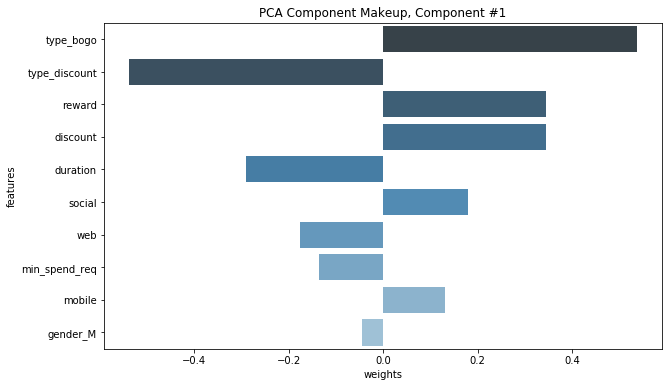

In [64]:
# display makeup of first component
num = 1
display_component(v, offers_completed_scaled.columns.values, component_num=num, n_weights=10)

Deploy the PCA model

In [65]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

-----------------------!CPU times: user 363 ms, sys: 15.5 ms, total: 378 ms
Wall time: 11min 33s


In [66]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [67]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -4.172325134277344e-07
      values: -7.46489376979298e-08
      values: -0.06646178662776947
      values: 0.07124936580657959
      values: -0.02305123209953308
      values: -0.020932674407958984
      values: 0.2202417254447937
      values: 0.039493411779403687
      values: 0.3357688784599304
      values: 0.17090952396392822
      values: -0.39080575108528137
      values: 0.7517983913421631
      values: 0.39193814992904663
      values: -0.7349555492401123
      values: 0.5673505067825317
    }
  }
}



Create a transformed dataframe.

In [68]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, scaled_df, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param scaled_df: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by itself, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    transformed_df = pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components = data.label['projection'].float32_tensor.values
        transformed_df = transformed_df.append([list(components)])

    # index by county, just like counties_scaled
    transformed_df.index = scaled_df.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    transformed_df = transformed_df.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return transformed_df.iloc[:, ::-1]

In [69]:
#TODO RERUN WITH SMALLER LIST OF TOP COMPONENTS ???


# specify top n 
top_n = 13

# call your function and create a new dataframe
completions_transformed = create_transformed_df(train_pca, offers_completed_scaled, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13']
completions_transformed.columns=PCA_list

# print result
completions_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13
2,0.567351,-0.734956,0.391938,0.751798,-0.390806,0.170910,0.335769,0.039493,0.220242,-0.020933,-0.023051,0.071249,-0.066462
5,0.464596,0.692469,0.489033,0.729918,0.174252,0.137160,0.173932,0.239588,0.239827,-0.114364,-0.028785,0.077211,-0.062486
10,0.461915,0.707243,0.481722,0.736035,0.162609,0.175268,-0.003991,0.200835,0.221765,-0.180850,-0.035222,0.078325,-0.061337
19,0.560618,-0.737416,0.409848,0.750598,0.077325,0.105822,0.407498,0.122299,0.246352,-0.294770,-0.031238,0.073092,-0.064964
21,0.465164,0.738330,0.444234,0.749099,-0.480143,0.327120,-0.405851,-0.080766,0.139285,-0.045578,-0.038670,0.077805,-0.061430


In [70]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

As we can see, there isn't much of a need to reduce dimentionality, so we will move onto another unsupervised algoritm.

## K-Means 

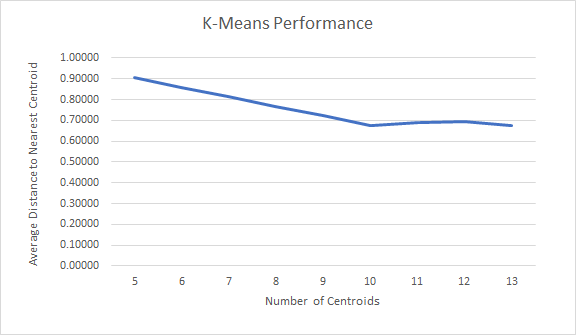

Running K-means multiple times and evaluating the average distances to the nearest centroid led me to decide on 10 being the optimal value for K.

In [184]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 10

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

In [185]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = completions_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [186]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data)

2020-02-10 09:18:31 Starting - Starting the training job...
2020-02-10 09:18:32 Starting - Launching requested ML instances......
2020-02-10 09:19:42 Starting - Preparing the instances for training......
2020-02-10 09:20:53 Downloading - Downloading input data...
2020-02-10 09:21:14 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[02/10/2020 09:21:38 INFO 139857489069888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1'


2020-02-10 09:21:47 Uploading - Uploading generated training model
2020-02-10 09:21:47 Completed - Training job completed
Training seconds: 54
Billable seconds: 54
CPU times: user 431 ms, sys: 24.5 ms, total: 455 ms
Wall time: 3min 42s


Deploy K-Means model

In [187]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

-----------------------!CPU times: user 368 ms, sys: 21.1 ms, total: 389 ms
Wall time: 11min 32s


Label and explore clusters.

In [188]:
# get the predicted clusters for all the kmeans training data
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [189]:
# print cluster info for first data point
data_idx = 0

print('Offer Completed is: ', completions_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

Offer Completed is:  2

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 6.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.7231946587562561
    }
  }
}



### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points and visualize the distribution of points over each cluster.

In [190]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

cluster_distances = [c.label['distance_to_cluster'].float32_tensor.values[0] for c in cluster_info]

In [191]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

distances_df = pd.DataFrame(cluster_distances)[0]

print(cluster_df)

3.0    6170
1.0    5647
5.0    3725
2.0    3688
8.0    2937
7.0    2432
0.0    2167
6.0    2021
9.0    1857
4.0    1800
Name: 0, dtype: int64


In [192]:
# calculate and display average distance to centroid for entire set 
# (recorded at each iteration of training and deploying k-means from 5 - 13)
distances_df.mean()

0.7154668594807324

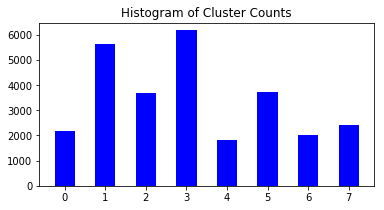

In [193]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

In [194]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

---
# Model Attributes & Explaination

By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, we can see some patterns about completed offers.

In [195]:
# download and unzip the kmeans model file from s3 bucket
kmeans_job_name = 'kmeans-2020-02-10-09-18-31-422'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')


2304

In [196]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[ 1.69391856e-01  6.91105306e-01  1.90836608e-01  5.33356071e-01
  -2.17427537e-02  7.65089989e-02 -1.04087023e-02  1.70646552e-02
   3.34180743e-02 -3.22856009e-04 -1.41017837e-03 -1.47514194e-02
   3.62060638e-03]
 [-6.72590017e-01 -7.63811290e-01 -3.17929000e-01 -7.36624151e-02
   2.53900159e-02 -2.20024586e-03  5.26052490e-02  3.97831947e-02
   1.69335045e-02  1.39440969e-02 -1.64609291e-02  9.74253193e-03
  -1.76115260e-02]
 [ 1.10264528e+00 -6.49428546e-01 -9.55553055e-02  6.92844391e-03
  -2.41808053e-02 -3.46554518e-01 -6.11634180e-02  1.77414548e-02
  -4.73237596e-02 -1.14922319e-02 -3.55512649e-03  1.02362379e-01
   2.29030009e-02]
 [-7.61983991e-01  6.52177691e-01 -1.97089940e-01 -9.68959928e-02
  -5.24170026e-02  1.66976228e-02 -2.30683796e-02 -5.28135151e-02
   5.28777251e-03 -1.09140137e-02 -1.55441547e-02  1.48078054e-02
  -1.19416090e-02]
 [ 1.20520163e+00  7.24240899e-01  1.90807670e-01 -7.04020977e-01
   3.56633887e-02  4.10284400e-01  1.04348868e-01  2.46990640e-0

In [197]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=completions_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13
0,0.169392,0.691105,0.190837,0.533356,-0.021743,0.076509,-0.010409,0.017065,0.033418,-0.000323,-0.001410,-0.014751,0.003621
1,-0.672590,-0.763811,-0.317929,-0.073662,0.025390,-0.002200,0.052605,0.039783,0.016934,0.013944,-0.016461,0.009743,-0.017612
2,1.102645,-0.649429,-0.095555,0.006928,-0.024181,-0.346555,-0.061163,0.017741,-0.047324,-0.011492,-0.003555,0.102362,0.022903
3,-0.761984,0.652178,-0.197090,-0.096896,-0.052417,0.016698,-0.023068,-0.052814,0.005288,-0.010914,-0.015544,0.014808,-0.011942
4,1.205202,0.724241,0.190808,-0.704021,0.035663,0.410284,0.104349,0.024699,-0.095512,0.002551,0.013274,-0.052200,0.001608
5,0.975291,0.751723,-0.084856,0.027371,-0.028226,-0.339792,-0.062183,-0.003243,-0.029244,0.001322,-0.008795,0.044365,0.031144
6,0.300856,-0.699646,0.078678,0.531056,-0.013949,0.046958,0.024668,-0.006183,0.047770,0.013234,-0.003048,-0.033507,0.006631
7,-0.623417,-0.787240,0.483903,-0.036514,-0.047980,-0.029800,-0.184984,-0.122759,0.015233,-0.030119,-0.020363,-0.033357,0.003672
8,-0.699429,0.545496,0.303172,-0.085827,0.155188,-0.104074,0.095681,0.100256,0.042073,0.019014,0.106140,-0.022907,-0.009669
9,1.295544,-0.661899,0.109266,-0.678869,0.053427,0.427863,0.062858,0.008489,-0.093110,-0.006015,-0.010406,-0.056407,0.001372


### Visualizing Centroids in Component Space

We can't visualize 13-dimensional centroids in space, but you can plot a heatmap of the centroids and their location in the transformed feature space. 

This gives insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA + clustering techniques, together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the PCA components.

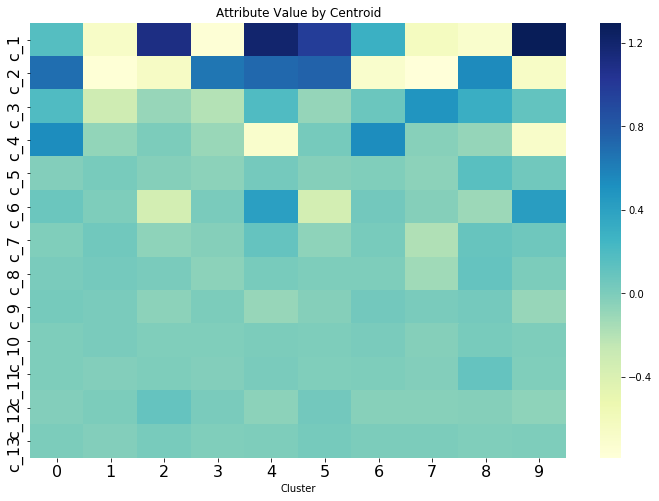

In [198]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,8))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

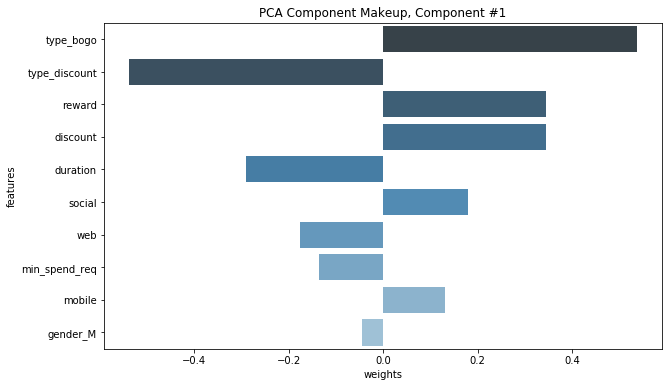

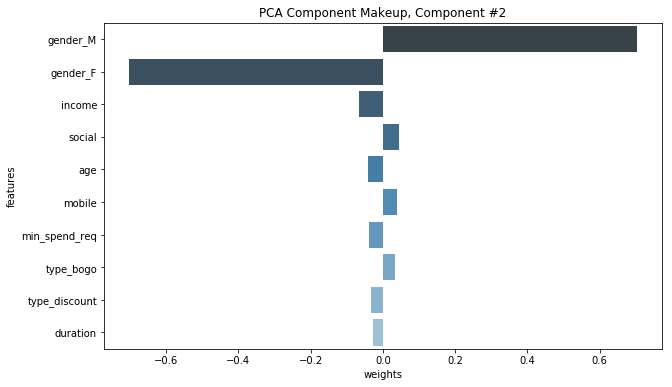

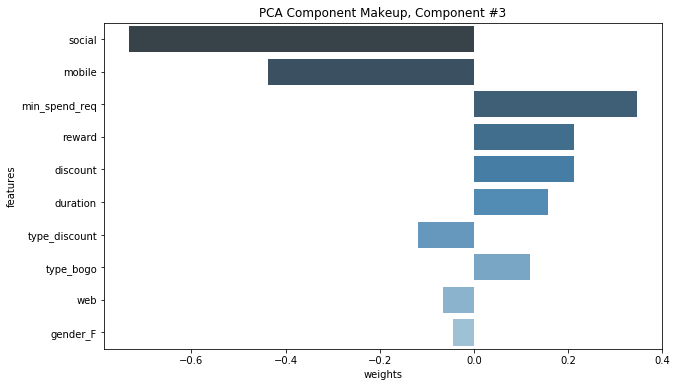

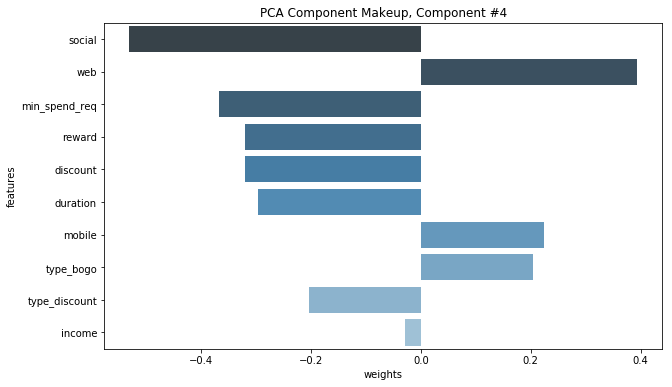

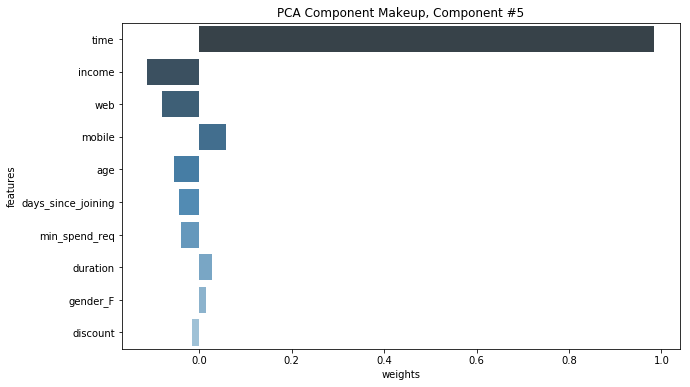

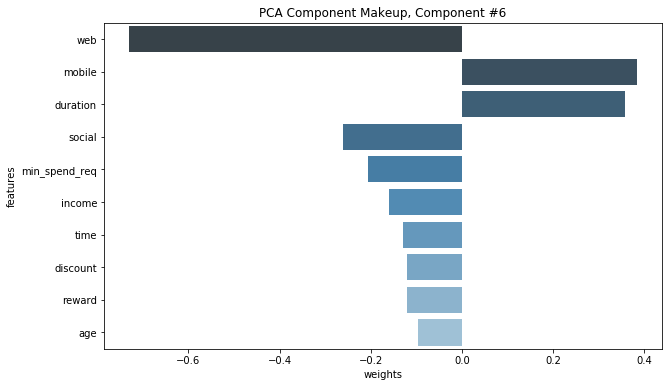

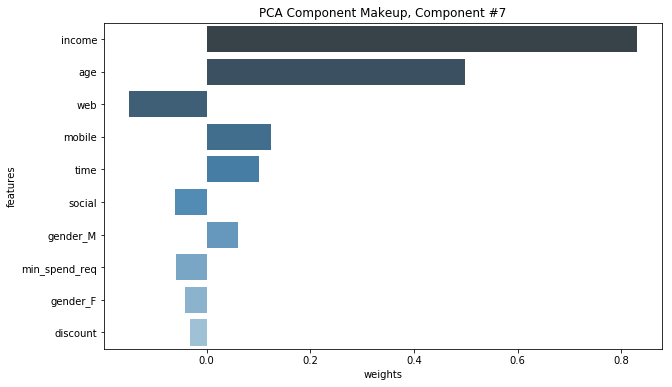

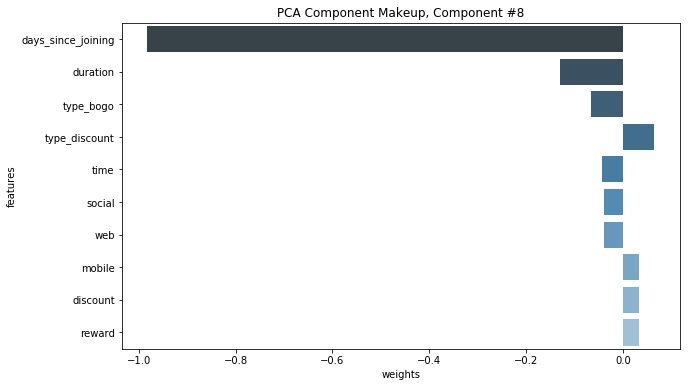

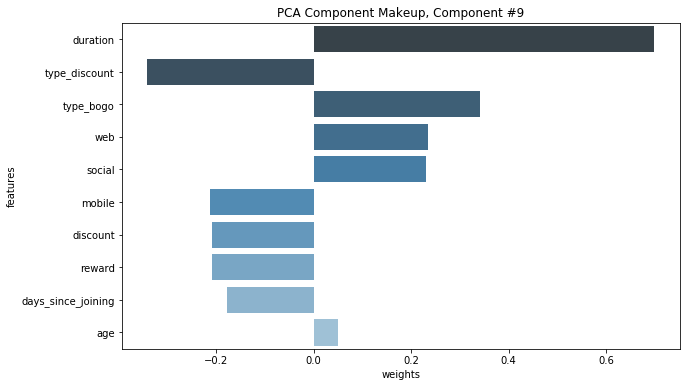

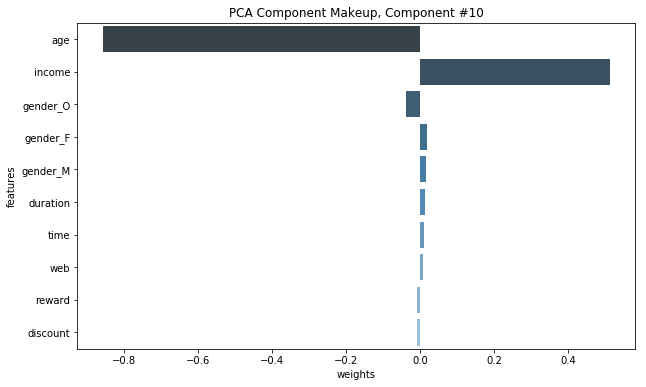

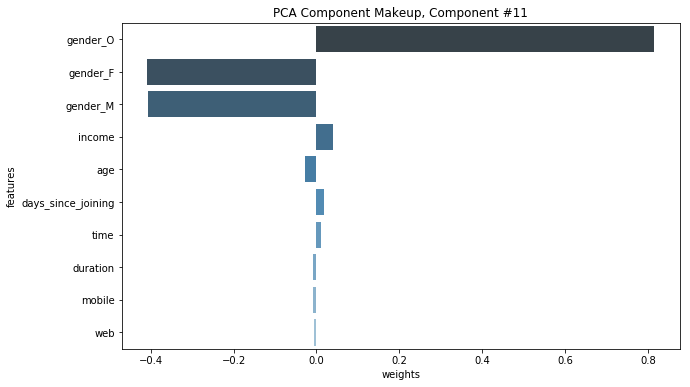

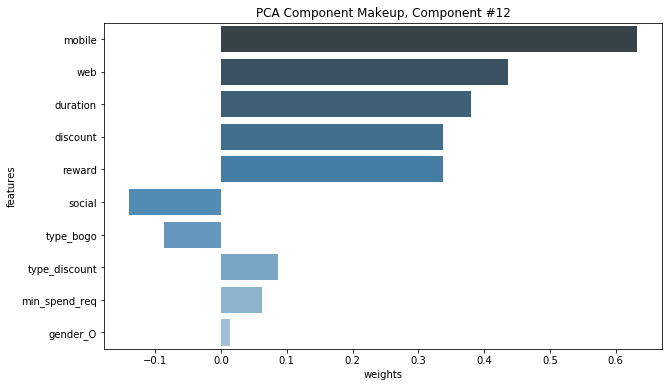

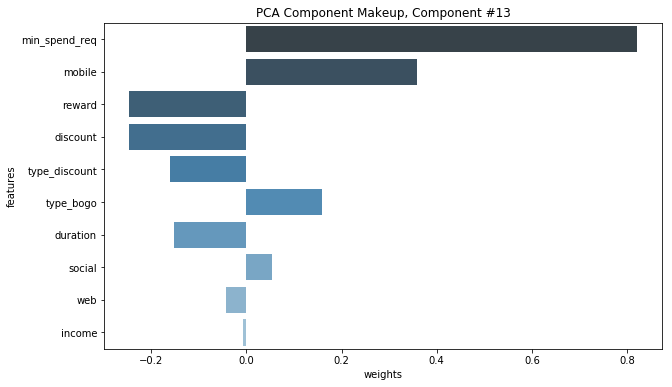

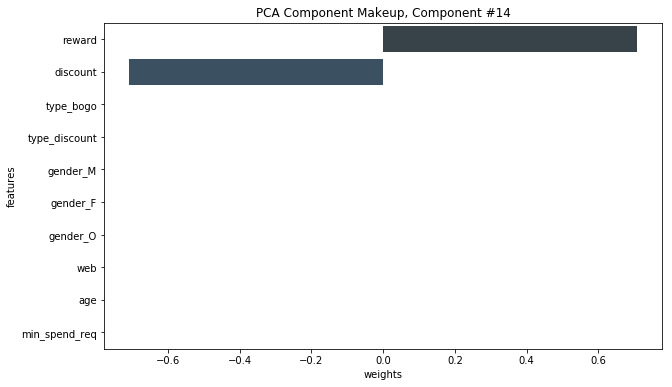

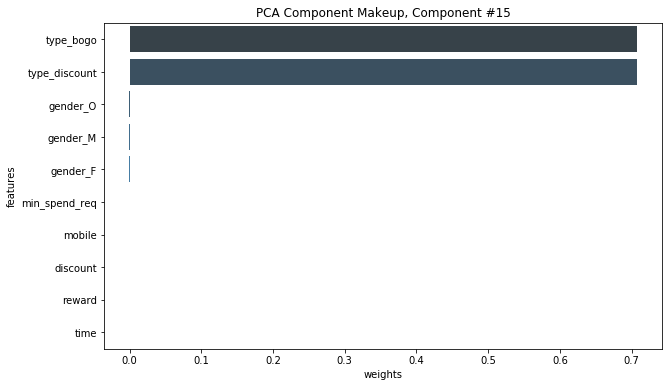

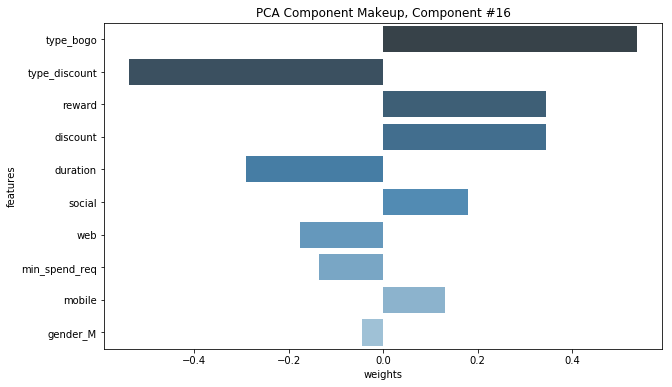

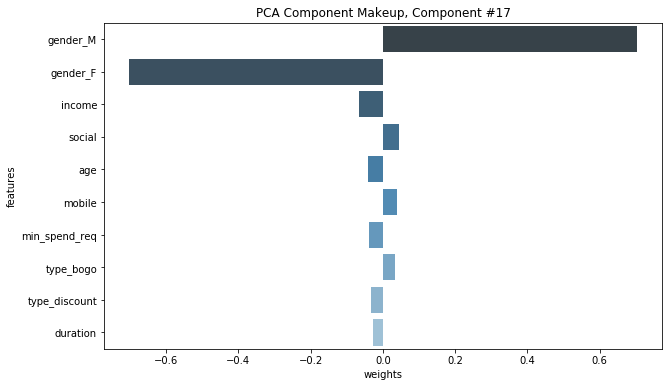

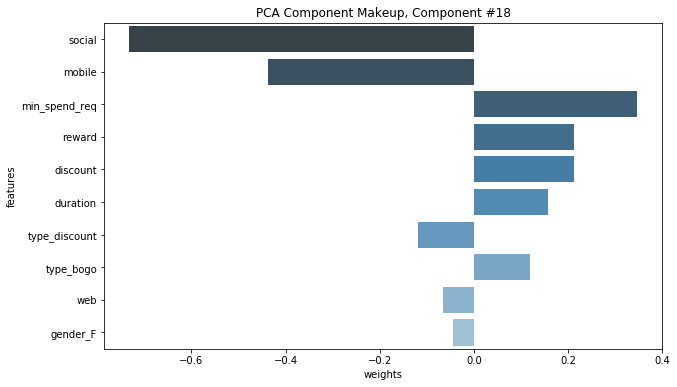

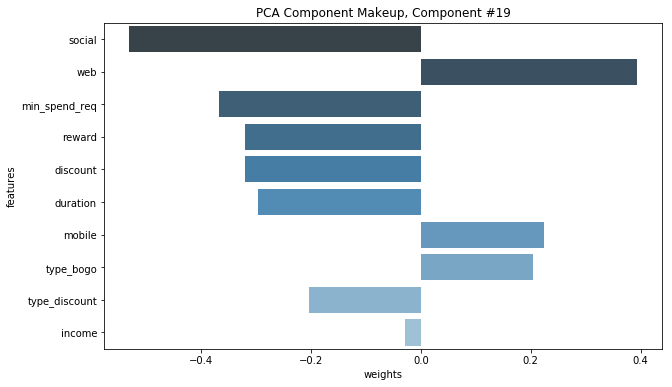

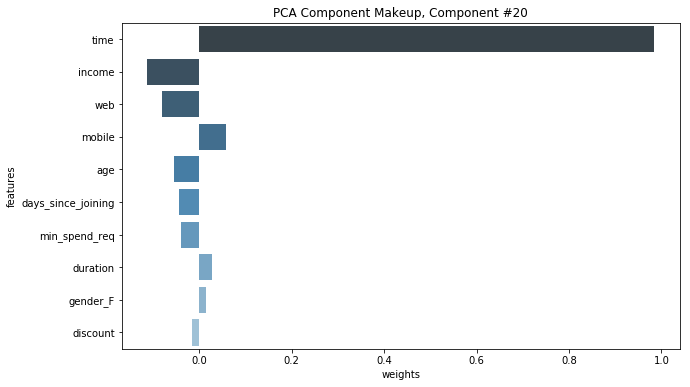

In [199]:
# what do each of these components mean again?
# let's use the display function, from above
for x in range(1,21):
    display_component(v, offers_completed_scaled.columns.values, component_num=x)

Natural Groupings

In [200]:
# add a 'labels' column to the dataframe
completions_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_completions = completions_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_completions.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,labels
10150,0.462319,0.716932,0.478080,0.736582,0.084825,0.206525,-0.117446,0.143606,0.193837,0.300381,-0.015824,0.076533,-0.061254,0
7970,0.458538,0.731996,0.470626,0.744030,0.108965,0.240666,-0.294046,0.099905,0.179239,0.022409,-0.031334,0.078577,-0.059852,0
7973,0.455090,0.732946,0.479575,0.743003,0.332375,0.211612,-0.271230,0.090163,0.179352,0.024958,-0.028631,0.078725,-0.059222,0
7985,0.466620,0.727613,0.454611,0.742592,-0.389840,0.289014,-0.269975,-0.029608,0.152066,0.257847,-0.022109,0.076090,-0.062152,0
7987,0.456795,0.717648,0.486730,0.733384,0.238319,0.147188,0.075821,-0.476547,0.101726,-0.014875,-0.013099,0.074174,-0.062729,0
7991,0.475585,0.683412,0.467005,0.727240,-0.534603,0.190816,0.278902,-0.068240,0.187921,0.011485,-0.021205,0.073602,-0.066280,0
7993,0.465367,0.686227,0.493518,0.724197,0.127351,0.104730,0.346502,-0.097105,0.188256,0.019036,-0.013194,0.074040,-0.064414,0
7999,0.469101,0.682344,0.487685,0.725460,-0.005009,0.131300,0.293930,0.184524,0.234914,0.037870,-0.019745,0.075349,-0.064124,0
8002,0.463098,0.683998,0.503261,0.723673,0.383888,0.080725,0.333645,0.167566,0.235111,0.042306,-0.015038,0.075606,-0.063028,0
7963,0.459389,0.715687,0.481971,0.733600,0.108074,0.164367,0.062510,-0.409266,0.111942,0.026202,-0.013874,0.074187,-0.063032,0


In [201]:
portfolio.apply(pd.value_counts) # to see counts of 1's and 0's

,min_spend_req,social,mobile,email,web,duration,id,discount,type_bogo,type_discount,type_informational
0,2.0,4.0,1.0,NaN,2.0,NaN,NaN,2.0,6.0,6.0,8.0
1,NaN,6.0,9.0,10.0,8.0,NaN,NaN,NaN,4.0,4.0,2.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,2.0,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN
7,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
10,4.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
20,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [202]:
profile.apply(pd.value_counts).head(2) # to see counts of 1's and 0's

,age,became_member_on,customer_id,income,gender_F,gender_M,gender_O,gender_none
0,NaN,NaN,NaN,NaN,10871.0,8516.0,16788.0,14825.0
1,NaN,NaN,NaN,NaN,6129.0,8484.0,212.0,2175.0


In [203]:
completed_offers.apply(pd.value_counts).head(2) # to see counts of 1's and 0's

,time,reward,age,days_since_joining,income,gender_F,gender_M,gender_O,min_spend_req,social,mobile,web,duration,discount,type_bogo,type_discount
0.0,204.0,NaN,NaN,NaN,NaN,16967.0,15978.0,31943.0,NaN,11485.0,3386.0,3657.0,NaN,NaN,17186.0,15258.0
1.0,NaN,NaN,NaN,NaN,NaN,15477.0,16466.0,501.0,NaN,20959.0,29058.0,28787.0,NaN,NaN,15258.0,17186.0


In [204]:
completed_offers.groupby('min_spend_req').count()

,time,reward,age,days_since_joining,income,gender_F,gender_M,gender_O,social,mobile,web,duration,discount,type_bogo,type_discount
min_spend_req,,,,,,,,,,,,,,,
5,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291,8291
7,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886,4886
10,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881,15881
20,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386,3386


# Conclusion

We can see here that there is a high correlation of the type of offer and the gender of the buyer in completed offers. (AND OTHER STUFF, NEED TO ADD MORE NOTICED DATA CORRELATIONS HERE....) 

This is useful for making successful targeted campaigns later, or for making offers reach the widest possible. 

Our data suggests that:

 - The top components that affect a successful promotion completion are:
     - PC1 : Bogo and discount offers.
     - PC2 : Are bought by people who prefer to state their gender as clearly male or female.
     - PC3/4 : Offers are distributed via social, web and mobile campaigns.  
     - PC5 : The length of time it took the customer to complete the reward.
     
 - Every single completed offer was sent out via email, but this isn't significant because all offers were sent via email. Also, their appears to be a direct correlation in the number of each type of offer available in the numbers completed. Thus the distribution channels don't seem to have much affect on completion rates.
 
 - It appears that none of the informational offers were completed, this is either significant because none were completed or not significant because maybe none of the informational offers had a way to be recorded as completed.
 
 - While an even porportion of bogo and discount offers were in the original portfolio, there seems to be more discount offers that made it to completion. (Would have to check versus number viewed/recieved to verify if this is due to customers preferring discounts over bogo or if this is because more discounts were sent out then bogos.)
 
 - While the number of males and females don't make up a drastically statistically important factor in the final total number of completions, comparing the number of females (6129) and males (8484) in the study to the number of females (15477) and males (16466) who completed the study reveals that each sex completed offers at a rate of 2.53 per female and 1.94 per male. (Also, a rate of 2.36 per person who identify as another sex.) This seems to indicate a slightly lower success rate of offers in the male customers despite males making up 38% more of their customer memborship base. 
 
 - The most successful completions were offers with a minimum spend of 10 dollars and 5 dollars, respectfully.